In [16]:
import numbers
import os
from typing import Tuple, TypeVar, Union

import matplotlib.pyplot as plt
import pandas as pd
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive

import pyro
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.dynamical.handlers.interruption import StaticEvent
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.ops import Dynamics, State, on, simulate
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.ops import Intervention, intervene
from chirho.observational.handlers import condition

R = Union[numbers.Real, torch.Tensor]
S = TypeVar("S")
T = TypeVar("T")


sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = "CI" in os.environ
num_samples = 10 if smoke_test else 300
exp_plate_size = 10 if smoke_test else 10000

In [17]:
class SIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        dX: State[torch.Tensor] = dict()
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]

        return dX


# TODO add running overshoot to states?


class SIRDynamicsLockdown(SIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    def forward(self, X: State[torch.Tensor]):
        self.beta = (1 - X["l"]) * self.beta0
        dX = super().forward(X)
        dX["l"] = torch.zeros_like(X["l"])
        return dX

In [18]:
init_state = dict(S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(12.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)
init_state_lockdown = dict(**init_state, l=torch.tensor(0.0))

# We now simulate from the SIR model
beta_true = torch.tensor([0.03])
gamma_true = torch.tensor([0.5])
sir_true = SIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory


def get_overshoot(trajectory):
    t_max = torch.argmax(trajectory["I"].squeeze())
    S_peak = torch.max(trajectory["S"].squeeze()[t_max]) / 100
    S_final = trajectory["S"].squeeze()[-1] / 100
    return (S_peak - S_final).item()


print(get_overshoot(sir_true_traj))

0.15116800367832184


In [19]:
def bayesian_sir(base_model=SIRDynamics) -> Dynamics[torch.Tensor]:
    beta = pyro.sample("beta", dist.Beta(18, 600))
    gamma = pyro.sample("gamma", dist.Beta(1600, 1600))
    sir = base_model(beta, gamma)
    return sir


def simulated_bayesian_sir(
    init_state, start_time, logging_times, base_model=SIRDynamics
) -> State[torch.Tensor]:
    sir = bayesian_sir(base_model)

    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

In [20]:
def MaskedStaticIntervention(time: R, intervention: Intervention[State[T]]):

    @on(StaticEvent(time))
    def callback(
        dynamics: Dynamics[T], state: State[T]
    ) -> Tuple[Dynamics[T], State[T]]:

        with pyro.poutine.block():
            return dynamics, intervene(state, intervention)

    return callback

In [21]:
overshoot_threshold = 20
lockdown_time = torch.tensor(1.0)
mask_time = torch.tensor(1.5)


def policy_model():

    lockdown = pyro.sample("lockdown", dist.Bernoulli(torch.tensor(0.5)))
    mask = pyro.sample("mask", dist.Bernoulli(torch.tensor(0.5)))

    lockdown_efficiency = pyro.deterministic(
        "lockdown_efficiency", torch.tensor(0.6) * lockdown, event_dim=0
    )

    mask_efficiency = pyro.deterministic(
        "mask_efficiency", (0.1 * lockdown + 0.45 * (1 - lockdown)) * mask, event_dim=0
    )

    joint_efficiency = pyro.deterministic(
        "joint_efficiency",
        torch.clamp(lockdown_efficiency + mask_efficiency, 0, 0.95),
        event_dim=0,
    )

    lockdown_sir = bayesian_sir(SIRDynamicsLockdown)
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with MaskedStaticIntervention(lockdown_time, dict(l=lockdown_efficiency)):
                with MaskedStaticIntervention(mask_time, dict(l=joint_efficiency)):
                    simulate(
                        lockdown_sir, init_state_lockdown, start_time, logging_times[-1]
                    )

    trajectory = lt.trajectory

    t_max = torch.max(trajectory["I"], dim=-1).indices
    S_peaks = pyro.ops.indexing.Vindex(trajectory["S"])[..., t_max]
    overshoot = pyro.deterministic(
        "overshoot", S_peaks - trajectory["S"][..., -1], event_dim=0
    )
    os_too_high = pyro.deterministic(
        "os_too_high",
        (overshoot > overshoot_threshold).clone().detach().float(),
        event_dim=0,
    )

    return overshoot, os_too_high


with ExtractSupports() as s:
    one_run = policy_model()


In [22]:
# conditioning (as opposed to intervening) is sufficient for
# propagating the changes, as the decisions are upstream from ds

# no interventions
policy_model_none = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)}
)
unintervened_predictive = Predictive(
    policy_model_none, num_samples=num_samples, parallel=True
)
unintervened_samples = unintervened_predictive()

# both interventions
policy_model_all = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)}
)
intervened_predictive = Predictive(
    policy_model_all, num_samples=num_samples, parallel=True
)
intervened_samples = intervened_predictive()

policy_model_mask = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(1.0)}
)
mask_predictive = Predictive(policy_model_mask, num_samples=num_samples, parallel=True)
mask_samples = mask_predictive()

policy_model_lockdown = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(0.0)}
)
lockdown_predictive = Predictive(
    policy_model_lockdown, num_samples=num_samples, parallel=True
)
lockdown_samples = lockdown_predictive()

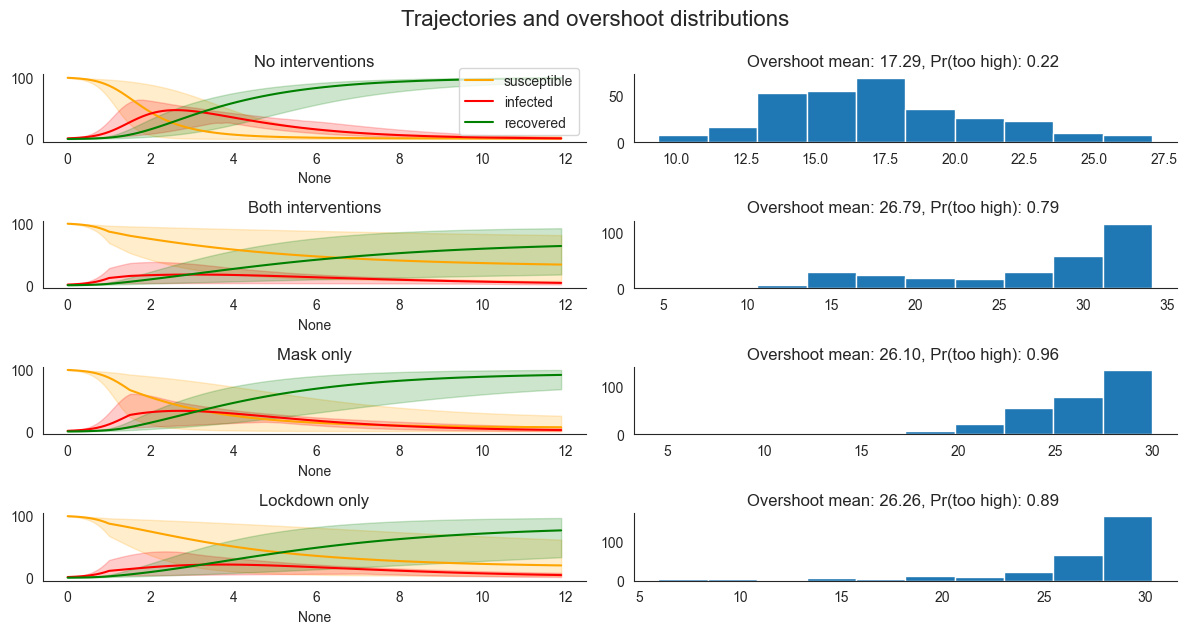

In [23]:
def add_pred_to_plot(preds, axs, coords, color, label):
    sns.lineplot(
        x=logging_times,
        y=preds.mean(dim=0).squeeze().tolist(),
        ax=axs[coords],
        label=label,
        color=color,
    )
    axs[coords].fill_between(
        logging_times,
        torch.quantile(preds, 0.025, dim=0).squeeze(),
        torch.quantile(preds, 0.975, dim=0).squeeze(),
        alpha=0.2,
        color=color,
    )


fig, axs = plt.subplots(4, 2, figsize=(12, 6))

colors = ["orange", "red", "green"]

add_pred_to_plot(
    unintervened_samples["S"], axs, coords=(0, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    unintervened_samples["I"], axs, coords=(0, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    unintervened_samples["R"], axs, coords=(0, 0), color=colors[2], label="recovered"
)

axs[0, 1].hist(unintervened_samples["overshoot"].squeeze())
axs[0, 0].set_title("No interventions")
axs[0, 1].set_title(
    f"Overshoot mean: {unintervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {unintervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    intervened_samples["S"], axs, coords=(1, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    intervened_samples["I"], axs, coords=(1, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    intervened_samples["R"], axs, coords=(1, 0), color=colors[2], label="recovered"
)
axs[1, 0].set_title("Both interventions")
axs[1, 0].legend_.remove()


axs[1, 1].hist(intervened_samples["overshoot"].squeeze())
axs[1, 1].set_title(
    f"Overshoot mean: {intervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {intervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    mask_samples["S"], axs, coords=(2, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    mask_samples["I"], axs, coords=(2, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    mask_samples["R"], axs, coords=(2, 0), color=colors[2], label="recovered"
)
axs[2, 0].set_title("Mask only")
axs[2, 0].legend_.remove()

axs[2, 1].hist(mask_samples["overshoot"].squeeze())
axs[2, 1].set_title(
    f"Overshoot mean: {mask_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {mask_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)

add_pred_to_plot(
    lockdown_samples["S"], axs, coords=(3, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    lockdown_samples["I"], axs, coords=(3, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    lockdown_samples["R"], axs, coords=(3, 0), color=colors[2], label="recovered"
)
axs[3, 0].set_title("Lockdown only")
axs[3, 0].legend_.remove()

axs[3, 1].hist(lockdown_samples["overshoot"].squeeze())
axs[3, 1].set_title(
    f"Overshoot mean: {lockdown_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {lockdown_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


fig.tight_layout()
fig.suptitle("Trajectories and overshoot distributions", fontsize=16, y=1.05)
sns.despine()

plt.savefig("counterfactual_sir.png")

In [24]:
with ExtractSupports() as s:
    policy_model()

supports = s.supports
print(supports.keys())

antecedents = {"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)}
alternatives = {"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)}
witnesses = {key: s.supports[key] for key in ["lockdown_efficiency", "mask_efficiency"]}
consequents = {"os_too_high": torch.tensor(1.0)}

with MultiWorldCounterfactual() as mwc:
    with SearchForExplanation(
        supports=supports,
        alternatives=alternatives,
        antecedents=antecedents,
        antecedent_bias=0.0,
        witnesses=witnesses,
        consequents=consequents,
        consequent_scale=1e-8,
        witness_bias=0.2,
    ):
        with pyro.plate("sample", exp_plate_size):
            with pyro.poutine.trace() as tr:
                policy_model_all()

dict_keys(['lockdown', 'mask', 'lockdown_efficiency', 'mask_efficiency', 'joint_efficiency', 'beta', 'gamma', 'S', 'I', 'R', 'l', 'overshoot', 'os_too_high'])


In [25]:
def get_table(
    trace, mwc, antecedents, witnesses, consequents, others=None, world: int = 1
):

    values_table = {}
    nodes = trace.trace.nodes
    witnesses = [key for key, _ in witnesses.items()]

    with mwc:

        for antecedent_str in antecedents.keys():

            obs_indices = IndexSet(
                **{
                    name: {0}
                    for name, ind in indices_of(nodes[antecedent_str]["value"]).items()
                }
            )
            obs_ant = gather(
                nodes[antecedent_str]["value"],
                obs_indices,
                event_dim=0,
            )

            int_indices = IndexSet(
                **{
                    name: {world}
                    for name, ind in indices_of(nodes[antecedent_str]["value"]).items()
                }
            )
            int_ant = gather(
                nodes[antecedent_str]["value"],
                int_indices,
                event_dim=0,
            )

            values_table[f"{antecedent_str}_obs"] = obs_ant.squeeze().tolist()
            values_table[f"{antecedent_str}_int"] = int_ant.squeeze().tolist()

            apr_ant = nodes[f"__cause____antecedent_{antecedent_str}"]["value"]
            values_table[f"apr_{antecedent_str}"] = apr_ant.squeeze().tolist()

        if witnesses:
            for candidate in witnesses:
                obs_indices = IndexSet(
                    **{
                        name: {world}
                        for name, ind in indices_of(nodes[candidate]["value"]).items()
                    }
                )
                obs_candidate = gather(
                    nodes[candidate]["value"],
                    obs_indices,
                    event_dim=0,
                )

                int_indices = IndexSet(
                    **{
                        name: {world}
                        for name, ind in indices_of(nodes[candidate]["value"]).items()
                    }
                )
                int_candidate = gather(
                    nodes[candidate]["value"],
                    int_indices,
                    event_dim=0,
                )

                values_table[f"{candidate}_obs"] = obs_candidate.squeeze().tolist()
                values_table[f"{candidate}_int"] = int_candidate.squeeze().tolist()

                wpr_con = nodes[f"__cause____witness_{candidate}"]["value"]
                values_table[f"wpr_{candidate}"] = wpr_con.squeeze().tolist()

        if others:
            for other in others:
                obs_indices = IndexSet(
                    **{
                        name: {0}
                        for name, ind in indices_of(nodes[other]["value"]).items()
                    }
                )

                obs_other = gather(
                    nodes[other]["value"],
                    obs_indices,
                    event_dim=0,
                )

                int_indices = IndexSet(
                    **{
                        name: {world}
                        for name, ind in indices_of(nodes[other]["value"]).items()
                    }
                )

                int_other = gather(
                    nodes[other]["value"],
                    int_indices,
                    event_dim=0,
                )

                values_table[f"{other}_obs"] = obs_other.squeeze().tolist()
                values_table[f"{other}_int"] = int_other.squeeze().tolist()

        for consequent in consequents.keys():

            obs_indices = IndexSet(
                **{
                    name: {0}
                    for name, ind in indices_of(nodes[consequent]["value"]).items()
                }
            )
            obs_consequent = gather(
                nodes[consequent]["value"],
                obs_indices,
                event_dim=0,
            )

            int_indices = IndexSet(
                **{
                    name: {world}
                    for name, ind in indices_of(nodes[consequent]["value"]).items()
                }
            )
            int_consequent = gather(
                nodes[consequent]["value"],
                int_indices,
                event_dim=0,
            )

            values_table[f"{consequent}_obs"] = obs_consequent.squeeze().tolist()
            values_table[f"{consequent}_int"] = int_consequent.squeeze().tolist()

    values_df = pd.DataFrame(values_table)

    return values_df


table = get_table(
    tr,
    mwc,
    antecedents,
    witnesses,
    consequents,
    others=["joint_efficiency", "overshoot"],
)

,lockdown_obs,lockdown_int,apr_lockdown,mask_obs,mask_int,apr_mask,lockdown_efficiency_obs,lockdown_efficiency_int,wpr_lockdown_efficiency,mask_efficiency_obs,mask_efficiency_int,wpr_mask_efficiency,joint_efficiency_obs,joint_efficiency_int,overshoot_obs,overshoot_int,os_too_high_obs,os_too_high_int
10,1.0,0.0,0,1.0,1.0,1,0.0,0.0,0,0.10,0.10,1,0.7,0.10,29.467434,18.516724,1.0,0.0
11,1.0,0.0,0,1.0,1.0,1,0.0,0.0,0,0.45,0.45,0,0.7,0.45,28.244480,27.621283,1.0,1.0
13,1.0,0.0,0,1.0,1.0,1,0.0,0.0,0,0.10,0.10,1,0.7,0.10,15.683098,23.994499,0.0,1.0
29,1.0,0.0,0,1.0,1.0,1,0.0,0.0,0,0.10,0.10,1,0.7,0.10,14.286774,23.541285,0.0,1.0
36,1.0,0.0,0,1.0,1.0,1,0.0,0.0,0,0.10,0.10,1,0.7,0.10,26.499218,20.113390,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9928,1.0,0.0,0,1.0,1.0,1,0.0,0.0,0,0.10,0.10,1,0.7,0.10,31.073330,18.907593,1.0,0.0
9941,1.0,0.0,0,1.0,1.0,1,0.0,0.0,0,0.45,0.45,0,0.7,0.45,28.345650,27.761520,1.0,1.0
9964,1.0,0.0,0,1.0,1.0,1,0.0,0.0,0,0.10,0.10,1,0.7,0.10,20.732349,22.889946,1.0,1.0
9983,1.0,0.0,0,1.0,1.0,1,0.0,0.0,0,0.45,0.45,0,0.7,0.45,26.055958,28.706375,1.0,1.0


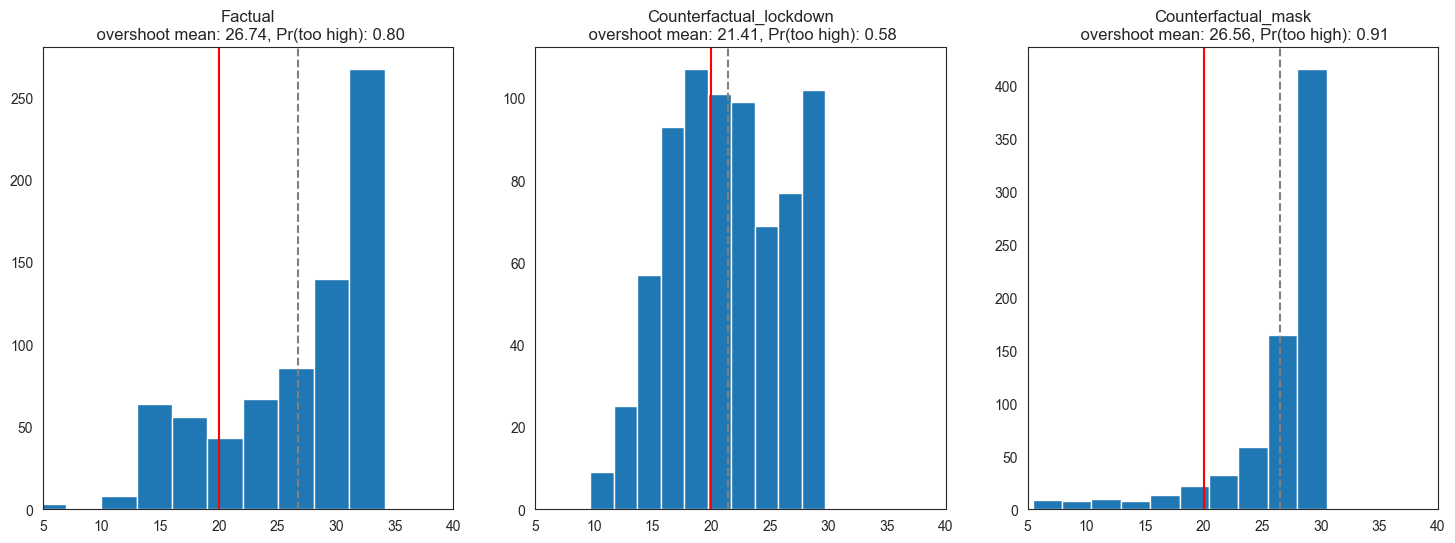

In [26]:
factual = table[
    (table["lockdown_int"] == 1)
    & (table["mask_int"] == 1)
    & (table["wpr_lockdown_efficiency"] == 0 & (table["wpr_mask_efficiency"] == 0))
]


counterfactual_lockdown = table[
    (table["lockdown_int"] == 0)
    & (table["mask_int"] == 1)
    & (table["wpr_lockdown_efficiency"] == 0)
]

display(counterfactual_lockdown)

counterfactual_mask = table[
    (table["lockdown_int"] == 1)
    & (table["mask_int"] == 0)
    & (table["wpr_mask_efficiency"] == 0)
]


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

factual_mean = factual["overshoot_int"].mean().item()
axs[0].hist(factual["overshoot_int"])
axs[0].set_title(
    f"Factual\n overshoot mean: {factual_mean:.2f}, Pr(too high): {factual['os_too_high_int'].mean().item():.2f}"
)
axs[0].axvline(x=factual_mean, color="grey", linestyle="--")

counterfactual_lockdown_mean = counterfactual_lockdown["overshoot_int"].mean()
axs[1].hist(counterfactual_lockdown["overshoot_int"])
axs[1].set_title(
    f"Counterfactual_lockdown\n overshoot mean: {counterfactual_lockdown_mean:.2f}, Pr(too high): {counterfactual_lockdown['os_too_high_int'].mean():.2f}"
)
axs[1].axvline(x=counterfactual_lockdown_mean, color="grey", linestyle="--")

counterfactual_mask_mean = counterfactual_mask["overshoot_int"].mean()
axs[2].hist(counterfactual_mask["overshoot_int"])
axs[2].set_title(
    f"Counterfactual_mask\n overshoot mean: {counterfactual_mask_mean:.2f}, Pr(too high): {counterfactual_mask['os_too_high_int'].mean():.2f}"
)
axs[2].axvline(x=counterfactual_mask_mean, color="grey", linestyle="--")

for i in range(3):
    axs[i].set_xlim(5, 40)
    axs[i].axvline(x=overshoot_threshold, color="red", linestyle="-")

plt.savefig("counterfactual_sir_search.png")
plt.show()

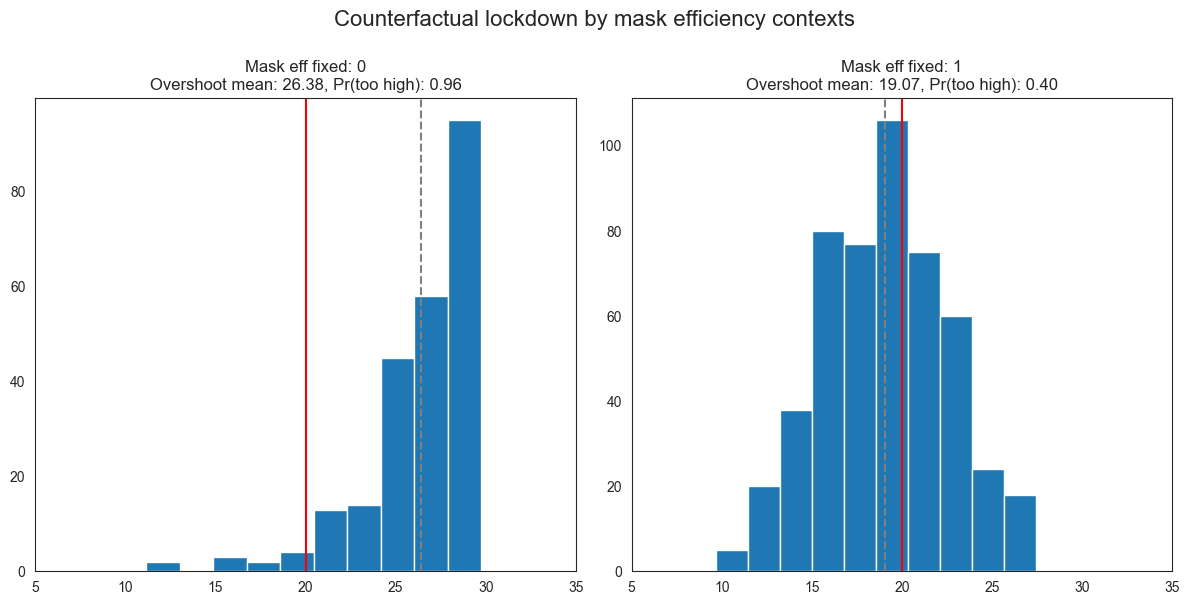

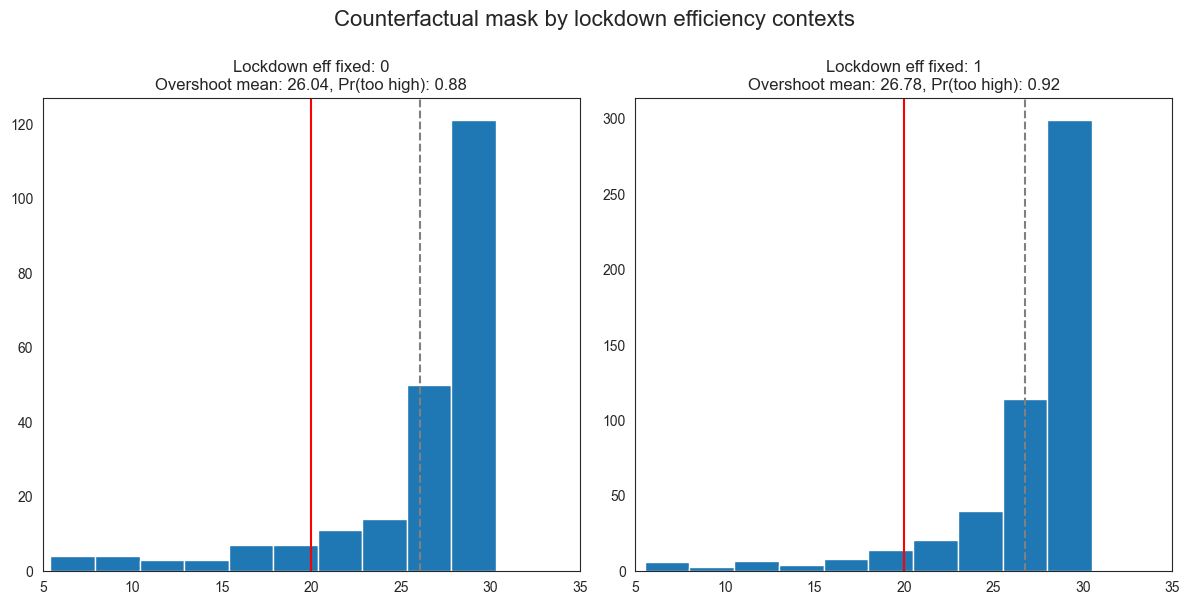

In [27]:
def plot_counterfactual_by_context(data, name, other):

    grouped_data = data.groupby(["wpr_lockdown_efficiency", "wpr_mask_efficiency"])

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    for (lockdown_efficiency, mask_efficiency), ax in zip(
        grouped_data.groups.keys(), axs.flatten()
    ):
        data_subset = grouped_data.get_group((lockdown_efficiency, mask_efficiency))
        mean_overshoot = data_subset["overshoot_int"].mean().item()

        fixed = mask_efficiency if name == "lockdown" else lockdown_efficiency
        ax.hist(data_subset["overshoot_int"])
        ax.set_title(
            f"{other} eff fixed: {fixed}\nOvershoot mean: {mean_overshoot:.2f}, Pr(too high): {data_subset['os_too_high_int'].mean().item():.2f}"
        )
        ax.set_xlim(5, 35)
        ax.axvline(x=mean_overshoot, color="grey", linestyle="--")
        ax.axvline(x=overshoot_threshold, color="red", linestyle="-")

    plt.suptitle(
        f"Counterfactual {name} by {other.lower()} efficiency contexts",
        fontsize=16,
        y=1,
    )
    plt.tight_layout()
    plt.show()


plot_counterfactual_by_context(counterfactual_lockdown, "lockdown", "Mask")

plot_counterfactual_by_context(counterfactual_mask, "mask", "Lockdown")

In [28]:
sufficiency_table = get_table(
    tr,
    mwc,
    antecedents,
    witnesses,
    consequents,
    world=2,
    others=["joint_efficiency", "overshoot"],
)


factual_sufficiency = sufficiency_table[
    (sufficiency_table["lockdown_int"] == 1)
    & (sufficiency_table["mask_int"] == 1)
    & (
        sufficiency_table["wpr_lockdown_efficiency"]
        == 0 & (sufficiency_table["wpr_mask_efficiency"] == 0)
    )
]

counterfactual_sufficiency_lockdown = sufficiency_table[
    (sufficiency_table["lockdown_int"] == 0)
    & (sufficiency_table["mask_int"] == 1)
    & (sufficiency_table["wpr_lockdown_efficiency"] == 0)
]

counterfactual_sufficiency_mask = sufficiency_table[
    (sufficiency_table["lockdown_int"] == 1)
    & (sufficiency_table["mask_int"] == 0)
    & (sufficiency_table["wpr_mask_efficiency"] == 0)
]


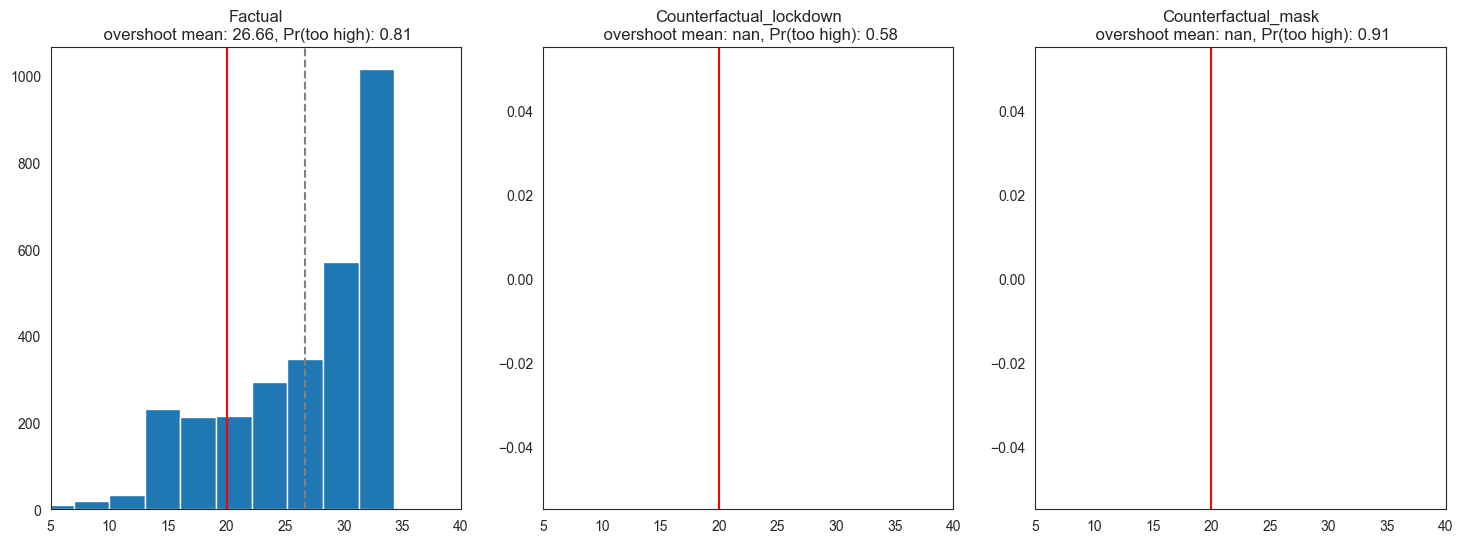

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

factual_sufficiency_mean = factual_sufficiency["overshoot_int"].mean().item()
axs[0].hist(factual_sufficiency["overshoot_int"])

axs[0].set_title((
    f"Factual\n overshoot mean: {factual_sufficiency_mean:.2f}, Pr(too high): "
    f"{factual_sufficiency['os_too_high_int'].mean().item():.2f}"
))
axs[0].axvline(x=factual_sufficiency_mean, color="grey", linestyle="--")

counterfactual_sufficiency_lockdown_mean = counterfactual_sufficiency_lockdown["overshoot_int"].mean()
axs[1].hist(counterfactual_sufficiency_lockdown["overshoot_int"])
axs[1].set_title((
    f"Counterfactual_lockdown\n overshoot mean: {counterfactual_sufficiency_lockdown_mean:.2f}, "
    f"Pr(too high): {counterfactual_lockdown['os_too_high_int'].mean():.2f}"
))
axs[1].axvline(x=counterfactual_sufficiency_lockdown_mean, color="grey", linestyle="--")

counterfactual_sufficiency_mask_mean = counterfactual_sufficiency_mask["overshoot_int"].mean()
axs[2].hist(counterfactual_sufficiency_mask["overshoot_int"])
axs[2].set_title((
    f"Counterfactual_mask\n overshoot mean: {counterfactual_sufficiency_mask_mean:.2f}, "
    f"Pr(too high): {counterfactual_mask['os_too_high_int'].mean():.2f}"
))
axs[2].axvline(x=counterfactual_sufficiency_mask_mean, color="grey", linestyle="--")

for i in range(3):
    axs[i].set_xlim(5, 40)
    axs[i].axvline(x=overshoot_threshold, color="red", linestyle="-")

#plt.savefig("counterfactual_sir_search_sufficiency.png")

plt.show()


In [30]:

counterfactual_sufficiency_lockdown.head()

,lockdown_obs,lockdown_int,apr_lockdown,mask_obs,mask_int,apr_mask,lockdown_efficiency_obs,lockdown_efficiency_int,wpr_lockdown_efficiency,mask_efficiency_obs,mask_efficiency_int,wpr_mask_efficiency,joint_efficiency_obs,joint_efficiency_int,overshoot_obs,overshoot_int,os_too_high_obs,os_too_high_int
